In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import os

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import LSTM, TimeDistributed, ConvLSTM2D

from sklearn.model_selection import train_test_split

In [2]:
data_path = os.getcwd() + "/dataset/raw_labelled/win_S01.csv"
# features = ["A_F", "A_V", "A_L", "L_F", "L_T", "L_L", "T_F", "T_V", "T_L"]

dataset = pd.read_csv(data_path)
time = list(dataset['time'])
dataframe = dataset[["A_F", "A_V", "A_L", "L_F", "L_V", "L_L", "T_F", "T_V", "T_L"]].values
# dataset = dataset[["A_F", "A_V", "A_L", "L_F", "L_V", "L_L", "T_F", "T_V", "T_L", "Action"]]

start = 21363
stop = 22003

In [3]:
dataset = dataset.loc[start:stop]

In [4]:
x = (dataset.loc[20403:22003,"time"]/64)-17000
y = dataset.loc[20403:22003,"A_V"]

y1 = dataset.loc[20403:22003,"L_V"]
y2 = dataset.loc[20403:22003,"T_V"]
color = dataset.loc[20403:22003,"Action"]

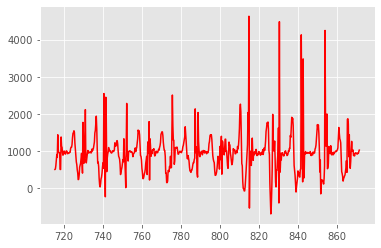

In [5]:
plt.style.use("ggplot") 

plt.plot(x, y, 'r')

In [6]:
dataset['time'] = (dataset['time'])/64-17000

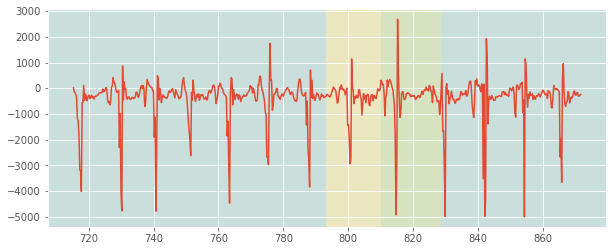

In [7]:
fig, ax = plt.subplots(figsize = (10, 4))



ax.plot(dataset['time'], dataset['A_F'])
ax.pcolorfast(ax.get_xlim(), ax.get_ylim(), dataset['Action'].values[np.newaxis],cmap='Set3', alpha=0.3)
plt.show()

In [8]:
data_path = os.getcwd() + "/dataset/raw_labelled/win_S01.csv"
# features = ["A_F", "A_V", "A_L", "L_F", "L_T", "L_L", "T_F", "T_V", "T_L"]

dataset = pd.read_csv(data_path)
time = list(dataset['time'])
dataframe = dataset[["A_F", "A_V", "A_L", "L_F", "L_V", "L_L", "T_F", "T_V", "T_L"]].values
# dataset = dataset[["A_F", "A_V", "A_L", "L_F", "L_V", "L_L", "T_F", "T_V", "T_L", "Action"]]

start = 22324
stop = 23124

dataset = dataset.loc[start:stop]

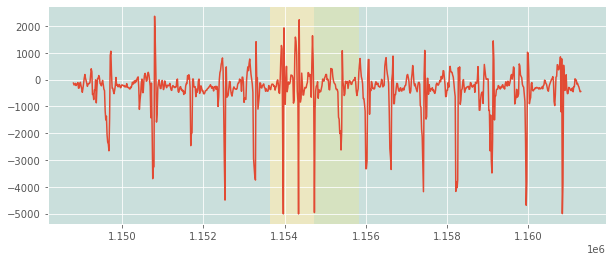

In [9]:
#dataset['time'] = (dataset['time'])/64-17000

fig, ax = plt.subplots(figsize = (10, 4))

ax.plot(dataset['time'], dataset['A_F'])
ax.pcolorfast(ax.get_xlim(), ax.get_ylim(), dataset['Action'].values[np.newaxis],cmap='Set3', alpha=0.3)
plt.show()

In [10]:
import os
import math
import pandas as pd

In [11]:
data_path = os.getcwd() + "/dataset/original_data"
first_processing_path = os.getcwd() +"/dataset/raw_labelled"
second_processing_path = os.getcwd() +"/dataset/windows"
final_dataset_path = os.getcwd() +"/dataset"
test_patients = ["S01", "S02"]

window_length = 1*64

In [12]:
'''
people[] -> 存所有在資料夾中的txt檔

'''
people = [] #S01R01.txt~S10R01.txt

for person in os.listdir(data_path):
    if '.txt' in person:
        people.append(person)


del person

In [13]:
def label_prefog(dataset, window_length):
# def label_prefog(dataset, window_length = 1):
    # Drop all the rows for which Action is 0 or the rows which are not part of the experiment
    # 將所有的Action==0(未實驗)的部分刪除，並不回傳任何值(implace的部分)
    dataset.drop(index = list(dataset[dataset['Action'] == 0].index),
                 inplace = True)
    
    # window_length = int(64*window_length)
    #print(window_length)
    fog_index = []
    for i in dataset.index:
        if dataset.loc[i, 'Action'] == 2: # 取index和'Action'對應到的資料
            fog_index.append(i) # 將發生fog的index存入fog_index這個array
    fog_index
    
    # print(fog_index)
    
    start_indices = []
    for i in fog_index:
        if (dataset.loc[i-1, 'Action'] != dataset.loc[i, 'Action']):
            start_indices.append(i) # 將發生fog之前的index存入start_indices這個array
    
    # print(start_indices)

    prefog = []
    for start in start_indices:
        prefog_start = [x for x in range(start-window_length, start)] # prefog_start把FOG之前的windows標記起來
        prefog.append(prefog_start)
        
    # print(prefog) # 2D array

    prefog = [item for sublist in prefog for item in sublist] # 把[][]轉換成[]

    # print(prefog) # 1D array

    for i in prefog:
        if(dataset.loc[i, "Action"] == 2):
            print (i, " ")
            continue
        dataset.loc[i,'Action'] = 3 # 把紀錄在Pre-fog的index action 記錄成3
    dataset['Action'] = dataset['Action'] - 1 # 所有action編號-1 使0=walk 1=fog 2= pre-fog
    return dataset

In [14]:
dataset = pd.DataFrame()
last_name = '' # 紀錄哪個是最終的病患
patients = [] # 病患ID list

for person in people:
    name = person.split('R')[0]

    if name != last_name:
        dataset = dataset.drop(index=dataset.index)
        patients.append(name)
    last_name = name
    print(name)

    file = data_path + "\\" + person

    if name in person:
        temp = pd.read_csv(file, delimiter = " ", header = None)
        print(person, ' is read', end = "\t")

        if 1 in temp[max(temp.columns)].unique():
            print("Adding {} to dataset".format(person), end = "\t")
            temp.columns = [
                                'time',
                                'A_F', 'A_V', 'A_L',
                                'L_F', 'L_V', 'L_L',
                                'T_F', 'T_V', 'T_L',
                                'Action'                           
                                ]
            
            temp = label_prefog(temp, window_length).reset_index(drop = True)
            temp['name'] = name
            print("{} is labelled".format(person))
            dataset = pd.concat([dataset, temp],axis = 0)
        print('')
    
        dataset.reset_index(drop = True, inplace = True)
        
        to_name = first_processing_path + "/win_" + name + ".csv"
    # 存入/raw_labelled中
    
    if not dataset.empty:
        dataset.to_csv(to_name, index = False)

del last_name, name, person, people, dataset, temp, to_name

S01
S01R01.txt  is read	Adding S01R01.txt to dataset	S01R01.txt is labelled

S01
S01R02.txt  is read	Adding S01R02.txt to dataset	S01R02.txt is labelled

S02
S02R01.txt  is read	Adding S02R01.txt to dataset	S02R01.txt is labelled

S02
S02R02.txt  is read	Adding S02R02.txt to dataset	S02R02.txt is labelled

S03
S03R01.txt  is read	Adding S03R01.txt to dataset	S03R01.txt is labelled

S03
S03R02.txt  is read	Adding S03R02.txt to dataset	22456  
S03R02.txt is labelled

S03
S03R03.txt  is read	Adding S03R03.txt to dataset	S03R03.txt is labelled

S04
S04R01.txt  is read	Adding S04R01.txt to dataset	S04R01.txt is labelled

S05
S05R01.txt  is read	Adding S05R01.txt to dataset	S05R01.txt is labelled

S05
S05R02.txt  is read	Adding S05R02.txt to dataset	S05R02.txt is labelled

S06
S06R01.txt  is read	Adding S06R01.txt to dataset	S06R01.txt is labelled

S06
S06R02.txt  is read	Adding S06R02.txt to dataset	S06R02.txt is labelled

S07
S07R01.txt  is read	Adding S07R01.txt to dataset	S07R01.txt is l

In [15]:
# temp = pd.read_csv(data_path + "\\" + "S03R02.txt", delimiter = " ", header = None)
# print("S03R02", ' is read', end = "\t")
# temp.columns = [
#                                 'time',
#                                 'A_F', 'A_V', 'A_L',
#                                 'L_F', 'L_V', 'L_L',
#                                 'T_F', 'T_V', 'T_L',
#                                 'Action'                           
#                                 ]

In [16]:
# time = list(temp['time'])
# dataframe = temp[["A_F", "A_V", "A_L", "L_F", "L_V", "L_L", "T_F", "T_V", "T_L"]].values
# # dataset = dataset[["A_F", "A_V", "A_L", "L_F", "L_V", "L_L", "T_F", "T_V", "T_L", "Action"]]

# start = 22136
# stop = 22776-1
# time_overLap = temp["time"][22456]

# temp = temp.loc[start:stop]
# temp = (temp-temp.mean())/(temp.max()-temp.min())

In [17]:
# temp['time'] = (temp['time'])

# fig, ax = plt.subplots(figsize = (10, 4))

# #temp_time = pd.Series(np.arange(0, 10, 1 / 64))

# ax.plot(temp["time"], temp['A_L'])
# ax.pcolorfast(ax.get_xlim(), ax.get_ylim(), temp['Action'].values[np.newaxis],cmap='Set3', alpha=0.3)
# ##ax.text(time_overLap, temp['A_L'][22456], "start label")
# plt.show()

In [35]:
train_data_path = os.getcwd() + "/dataset/total_train.csv"
test_data_path = os.getcwd() + "/dataset/total_test.csv"
# features = ["A_F", "A_V", "A_L", "L_F", "L_T", "L_L", "T_F", "T_V", "T_L"]

train_dataset = pd.read_csv(train_data_path)
train_time = list(train_dataset['time'])
temp_action = list(train_dataset['Action'])

train_df_only_data = train_dataset[["A_F", "A_V", "A_L", "L_F", "L_V", "L_L", "T_F", "T_V", "T_L"]]

train_dataframe = train_dataset[["A_F", "A_V", "A_L", "L_F", "L_V", "L_L", "T_F", "T_V", "T_L"]].values
train_dataset = train_dataset[["A_F", "A_V", "A_L", "L_F", "L_V", "L_L", "T_F", "T_V", "T_L", "Action"]].values

window_length = int(1*64)
train_total_windows = int((len(train_dataset))/window_length)

In [19]:
test_patients = ["S01", "S02"]

test_dataset = pd.read_csv(test_data_path)
test_time = list(test_dataset['time'])
test_dataframe = test_dataset[["A_F", "A_V", "A_L", "L_F", "L_V", "L_L", "T_F", "T_V", "T_L"]].values
test_dataset = test_dataset[["A_F", "A_V", "A_L", "L_F", "L_V", "L_L", "T_F", "T_V", "T_L", "Action"]].values

test_total_windows = int((len(test_dataset))/window_length)

In [20]:
train_dataframe = (train_dataframe-train_dataframe.mean())/(train_dataframe.std())
test_dataframe = (test_dataframe-test_dataframe.mean())/(test_dataframe.std())

In [21]:
indices = train_time
groups = []
group_count = 0
temp = []
lenOfGroup = []
length_count = 0

for i in range(len(indices)):
    if i == (len(indices) - 1):
        temp.append(indices[i])
        length_count = length_count + 1

        groups.append(temp)
        lenOfGroup.append(length_count)
        length_count = 0
        temp = []
        break
    temp.append(indices[i])
    length_count = length_count + 1
    if (indices[i+1] - 20 > indices[i]):
        group_count = group_count + 1

        lenOfGroup.append(length_count)
        length_count = 0

        groups.append(temp)
        temp = []

del temp, indices, group_count, length_count, i

countOfUndivisible = 0
total_windows_with_overlap_train = 0

start_index = 0

stop_Indexs = []
stop_Index = -window_length


for lengths in lenOfGroup:
    stop_Index = stop_Index + lengths
    stop_Indexs.append(stop_Index)
    total_windows_with_overlap_train = total_windows_with_overlap_train + int(float(lengths/window_length)*2 -1)
    
    if lengths % (window_length/2) != 0:
        countOfUndivisible = countOfUndivisible + 1
        print(lengths)

print(countOfUndivisible)
del countOfUndivisible, lengths

0


In [22]:
col = list(train_df_only_data.columns)

In [23]:
from scipy.signal import butter, lfilter

In [24]:
order = 5
pre_line = 0
post_line = 0

fi = pd.DataFrame()
power = pd.DataFrame()


for column in col:
    xtemp = []
    xtemp1 = []
    for i in lenOfGroup:
        post_line += i
        for j in range(pre_line, post_line-32, 32):
            nyq = 0.5*64

            loc_low = 0.5 / nyq
            loc_high = 3 / nyq

            b, a = butter(order, [loc_low, loc_high], btype='band')
            y = lfilter(b, a, train_df_only_data[column].iloc[j:j+64])

            e1 = sum([x**2 for x in y])
            #==========================
            frez_low = 3 / nyq
            frez_high = 8 / nyq

            b1, a1 = butter(order, [frez_low, frez_high], btype='band')
            y1 = lfilter(b1, a1, train_df_only_data[column].iloc[j:j+64])

            e2 = sum([x**2 for x in y1])

            freezing_index = e2/e1
            pwr = e2 + e1


            xtemp.append(freezing_index)
            xtemp1.append(pwr)

        pre_line = post_line
    print(column + " done", end = " ")
    pre_line = 0
    post_line = 0
    fi['FI_' + column] = xtemp
    power['P_' + column] = xtemp1


print(" Freezing Index and Power has been calculated")

A_F done A_V done A_L done 

C:\Users\ESALAB~1\AppData\Local\Temp/ipykernel_22236/3963498034.py:33: RuntimeWarning: invalid value encountered in double_scalars
  freezing_index = e2/e1


L_F done L_V done L_L done T_F done T_V done T_L done  Freezing Index and Power has been calculated


In [36]:
y = np.empty((total_windows_with_overlap_train, 1))

stop_Index = 0
window_count = 0

for window in range(total_windows_with_overlap_train):
    for i in range(window_length):
        if i == 0:
            y[window] = train_dataset[int(window_count*window_length), 9]
        if stop_Index < len(stop_Indexs):
            if int(window_count*window_length) == stop_Indexs[stop_Index]:
                window_count = window_count + 0.5
                stop_Index = stop_Index + 1
    window_count = window_count + 0.5

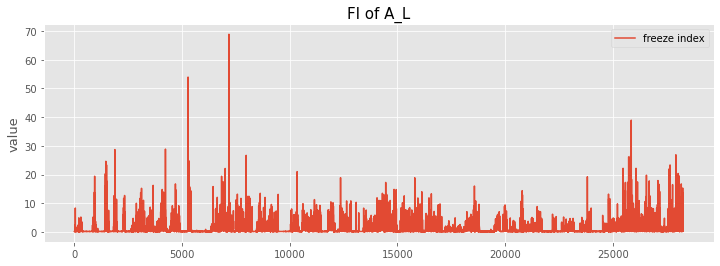

In [45]:
# start_Index = 0
# for i in range(1):
#     start_index += lenOfGroup[i]

# start_Index = int(start_Index/64)
# stop_Index = int((lenOfGroup[i+1]+start_Index)/64)

start_Index = 0
stop_Index = len(fi)


temp_time = train_time[start_Index:stop_Index]
temp_A_L_f = fi['FI_A_L'].iloc[start_Index:stop_Index]
# temp_A_L_P = power['P_A_L'].iloc[start_Index:stop_Index]
# temp_A_L_O = train_dataframe[start_Index:stop_Index, 1]
temp_action = y[start_Index:stop_Index]


fig, ax = plt.subplots(figsize = (12, 4))

#temp_time = pd.Series(np.arange(0, 10, 1 / 64))

# plt.plot(temp_time, temp_A_L_P, label = 'power')
ax.plot(range(len(temp_A_L_f)), temp_A_L_f, label = 'freeze index')
# plt.plot(temp_time, temp_A_L_O, label = 'origin')
# ax.pcolorfast(ax.get_xlim(), ax.get_ylim(), temp_action[np.newaxis],cmap='Set3', alpha=0.3)
# ax.text(time_overLap, temp['A_L'][22456], "start label")
plt.title('FI of A_L', fontsize = 15)
# plt.xlabel("time (ms)",fontsize=13)
plt.ylabel("value",fontsize=13)
ax.legend()
plt.show()

In [ ]:
data_path = os.getcwd() + "/dataset/freezeIndex.csv"
fi.to_csv(data_path, index=False)

data_path = os.getcwd() + "/dataset/power.csv"
power.to_csv(data_path, index=False)

In [ ]:
indices = test_time
groups = []
group_count = 0
temp = []
lenOfGroup = []
length_count = 0

for i in range(len(indices)):
    if i == (len(indices) - 1):
        temp.append(indices[i])
        length_count = length_count + 1

        groups.append(temp)
        lenOfGroup.append(length_count)
        length_count = 0
        temp = []
        break
    temp.append(indices[i])
    length_count = length_count + 1
    if (indices[i+1] - 20 > indices[i]):
        group_count = group_count + 1

        lenOfGroup.append(length_count)
        length_count = 0

        groups.append(temp)
        temp = []

del temp, indices, group_count, length_count, i

countOfUndivisible = 0
total_windows_with_overlap_test = 0

start_index = 0

stop_Indexs = []
stop_Index = -window_length


for lengths in lenOfGroup:
    stop_Index = stop_Index + lengths
    stop_Indexs.append(stop_Index)
    total_windows_with_overlap_test = total_windows_with_overlap_test + int(float(lengths/window_length)*2 -1)
    
    if lengths % (window_length/2) != 0:
        countOfUndivisible = countOfUndivisible + 1
        print(lengths)

print(countOfUndivisible)
del countOfUndivisible, lengths

0


In [ ]:
order = 5
pre_line = 0
post_line = 0

fi = pd.DataFrame()
power = pd.DataFrame()


for column in col:
    xtemp = []
    xtemp1 = []
    for i in lenOfGroup:
        post_line += i
        for j in range(pre_line, post_line-32, 32):
            nyq = 0.5*64

            loc_low = 0.5 / nyq
            loc_high = 3 / nyq

            b, a = butter(order, [loc_low, loc_high], btype='band')
            y = lfilter(b, a, train_df_only_data[column].iloc[j:j+64])

            e1 = sum([x**2 for x in y])
            #==========================
            frez_low = 3 / nyq
            frez_high = 8 / nyq

            b1, a1 = butter(order, [frez_low, frez_high], btype='band')
            y1 = lfilter(b1, a1, train_df_only_data[column].iloc[j:j+64])

            e2 = sum([x**2 for x in y1])

            freezing_index = e2/e1
            pwr = e2 + e1


            xtemp.append(freezing_index)
            xtemp1.append(pwr)

        pre_line = post_line
    print(column + " done", end = " ")
    pre_line = 0
    post_line = 0
    fi['FI_' + column] = xtemp
    power['P_' + column] = xtemp1


print(" Freezing Index and Power has been calculated")

A_F done A_V done A_L done 

C:\Users\ESALAB~1\AppData\Local\Temp/ipykernel_28024/3963498034.py:33: RuntimeWarning: invalid value encountered in double_scalars
  freezing_index = e2/e1


L_F done L_V done L_L done T_F done T_V done T_L done  Freezing Index and Power has been calculated
